In [2]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn import Parameter
import matplotlib.pyplot as plt
import numpy as np

# This is heavily based on the given solution for the class VAE exercise

In [3]:
import os
os.makedirs("results", exist_ok=True)

cuda2 = False # torch.cuda.is_available() check if a gpu is available
batch_size2 = 128
log_interval2 = 10
epochs2 = 2 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD # -ELBO

def train(model, optimizer, epoch):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2
        self.fc3 = nn.Linear(2, 100) # 20 -> 2
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        mu, logvar = self.fc21(h2), self.fc22(h2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        gauss, mu, logvar = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        return self.decode(z), mu, logvar

In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train(model, optimizer, epoch)
    test(model, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 188.5641
====> Test set loss: 166.2249
====> Epoch: 2 Average loss: 162.5552
====> Test set loss: 159.3404


### Find expected value in latent space for each number

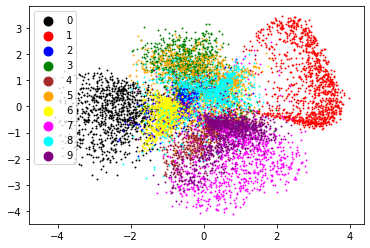

In [ ]:
def test_expected_value_in_latent_space(encoder):
    with torch.no_grad():
        zs = []
        ys = []
        for i, (data, y) in enumerate(test_loader):
            data = data.to(device)
            _z, mu, _logvar = encoder(data)
            zs.append(mu)
            ys.append(y)
        zs = torch.cat(zs)
        ys = torch.cat(ys)
    zs = zs.detach().numpy()
    ys = ys.detach().numpy()
    return zs, ys

def plot_latent_space(encoder):
    zs, ys = test_expected_value_in_latent_space(encoder)
    z1, z2 = zs.T

    cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
             5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

    fig, ax = plt.subplots()
    for y in np.unique(ys):
        ix = np.where(ys == y)
        ax.scatter(z1[ix], z2[ix], c = cdict[y], label = int(y), s = 0.8)
    ax.legend(markerscale = 10)
    plt.show()

plot_latent_space(lambda x: model.encode(x.view(-1, 784)))

# 2. Now let's visualize the output in a different way...

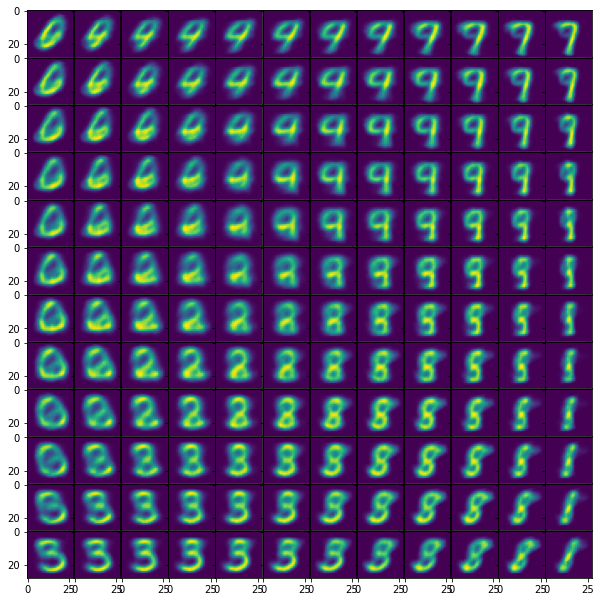

In [ ]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

# Convolutional VAE

In [ ]:
# Define VAE model
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, stride=1)
        self.conv_mean   = nn.Conv2d(32, 64, 3, stride=2)
        self.conv_logvar = nn.Conv2d(32, 64, 3, stride=2)
        self.fc_mean   = nn.Linear(12*12*64, 2)
        self.fc_logvar = nn.Linear(12*12*64, 2)
        self.fc1 = nn.Linear(2, 12*12*64)
        self.conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(32, 1, 3, stride=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x1 = F.relu(self.conv_mean(x)).view(-1, 12*12*64)
        x2 = F.relu(self.conv_logvar(x)).view(-1, 12*12*64)
        mu, logvar = self.fc_mean(x1), self.fc_logvar(x2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar

    def decode(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.conv2(z.view(-1, 64, 12, 12)))
        return torch.sigmoid(self.conv3(z))

    def forward(self, x):
        gauss, mu, logvar = self.encode(x)
        z = gauss.rsample()
        return self.decode(z).view(-1, 784), mu, logvar

In [ ]:
os.makedirs("results/conv", exist_ok=True)

conv_model = ConvVAE().to(device)
optimizer = optim.Adam(conv_model.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train(conv_model, optimizer, epoch)
    test(conv_model, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device)
        sample = conv_model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/conv/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 217.6536
====> Test set loss: 176.1444
====> Epoch: 2 Average loss: 171.4872
====> Test set loss: 168.3343


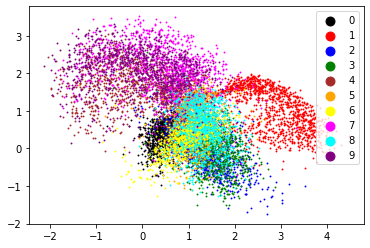

In [ ]:
plot_latent_space(conv_model.encode)

In [ ]:
#x, y = iter(train_loader).next()
#x.shape, y.shape

# Bayesian VAE

In [5]:
import math

In [6]:
torch.zeros(2,3,5)

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [7]:
# Define Bayesian VAE model
class BVAE222(nn.Module):
    def __init__(self):
        super(BVAE222, self).__init__()

        #phi(for z)
        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2

        #phi(for theta)
        self.weight_mu_theta1 = Parameter(torch.zeros(784, 2))
        self.weight_logvar_theta1 = Parameter(torch.zeros(784, 2))
        self.bias_mu_theta1 = Parameter(torch.zeros(784))
        self.bias_logvar_theta1 = Parameter(torch.zeros(784))


        #theta
        #self.fc3 = nn.Linear(2, 100) # 20 -> 2
        #self.fc3a = nn.Linear(100, 400)
        #self.fc4 = nn.Linear(400, 784)
        self.init_parameters()

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        mu, logvar = self.fc21(h2), self.fc22(h2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar
    
    def init_parameters(self):
        stdv1 = 1. / math.sqrt(self.weight_mu_theta1.size(1))
        self.weight_mu_theta1.data.uniform_(-stdv1, stdv1)
        self.weight_logvar_theta1.data.uniform_(-stdv1, stdv1)
        self.bias_mu_theta1.data.uniform_(-stdv1, stdv1)
        self.bias_logvar_theta1.data.uniform_(-stdv1, stdv1)

    def decode(self, z):
        #weight = torch.distributions.normal.Normal(self.weight_mu_theta, torch.exp(0.5*self.weight_logvar_theta)).rsample()
        #bias = torch.distributions.normal.Normal(self.bias_mu_theta, torch.exp(0.5*self.bias_logvar_theta)).rsample()
        #Draw theta
        weight1 = self.weight_mu_theta1 + torch.exp(0.5*self.weight_logvar_theta1) * torch.randn_like(self.weight_logvar_theta1)
        bias1 = self.bias_mu_theta1 + torch.exp(0.5*self.bias_logvar_theta1) * torch.randn_like(self.bias_logvar_theta1)
    
        #Forward propagation using paramters
        h3 = F.relu(F.linear(z, weight1, bias1))
        mu_theta = torch.concatenate([self.weight_mu_theta1.view(1,-1), self.bias_mu_theta1.view(1,-1)], dim=1)
        logvar_theta = torch.concatenate([self.weight_logvar_theta1.view(1,-1), self.bias_logvar_theta1.view(1,-1)], dim=1)
        return torch.sigmoid(h3), mu_theta, logvar_theta

    def forward(self, x):
        gauss, mu, logvar = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        x_hat, mu_theta, logvar_theta = self.decode(z)
        return x_hat, mu, logvar, mu_theta, logvar_theta

In [8]:
# Define Bayesian VAE model
class BVAE(nn.Module):
    def __init__(self):
        super(BVAE, self).__init__()

        #phi(for z)
        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # 20 -> 2
        self.fc22 = nn.Linear(100, 2) # 20 -> 2

        #phi(for theta)
        self.weight_mu_theta1 = Parameter(torch.zeros(100, 2))
        self.weight_logvar_theta1 = Parameter(torch.zeros(100, 2))
        self.bias_mu_theta1 = Parameter(torch.zeros(100))
        self.bias_logvar_theta1 = Parameter(torch.zeros(100))
        self.weight_mu_theta2 = Parameter(torch.zeros(400, 100))
        self.weight_logvar_theta2 = Parameter(torch.zeros(400, 100))
        self.bias_mu_theta2 = Parameter(torch.zeros(400))
        self.bias_logvar_theta2 = Parameter(torch.zeros(400))
        self.weight_mu_theta3 = Parameter(torch.zeros(784, 400))
        self.weight_logvar_theta3 = Parameter(torch.zeros(784, 400))
        self.bias_mu_theta3 = Parameter(torch.zeros(784))
        self.bias_logvar_theta3 = Parameter(torch.zeros(784))

        #theta
        #self.fc3 = nn.Linear(2, 100) # 20 -> 2
        #self.fc3a = nn.Linear(100, 400)
        #self.fc4 = nn.Linear(400, 784)
        self.init_parameters()

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        mu, logvar = self.fc21(h2), self.fc22(h2)
        return torch.distributions.normal.Normal(mu, torch.exp(0.5*logvar)), mu, logvar
    
    def init_parameters(self):
        stdv1 = 1. / math.sqrt(self.weight_mu_theta1.size(1))
        self.weight_mu_theta1.data.uniform_(-stdv1, stdv1)
        self.weight_logvar_theta1.data.uniform_(-stdv1, stdv1)
        self.bias_mu_theta1.data.uniform_(-stdv1, stdv1)
        self.bias_logvar_theta1.data.uniform_(-stdv1, stdv1)
        stdv2 = 1. / math.sqrt(self.weight_mu_theta2.size(1))
        self.weight_mu_theta2.data.uniform_(-stdv2, stdv2)
        self.weight_logvar_theta2.data.uniform_(-stdv2, stdv2)
        self.bias_mu_theta2.data.uniform_(-stdv2, stdv2)
        self.bias_logvar_theta2.data.uniform_(-stdv2, stdv2)
        stdv3 = 1. / math.sqrt(self.weight_mu_theta3.size(1))
        self.weight_mu_theta3.data.uniform_(-stdv3, stdv3)
        self.weight_logvar_theta3.data.uniform_(-stdv3, stdv3)
        self.bias_mu_theta3.data.uniform_(-stdv3, stdv3)
        self.bias_logvar_theta3.data.uniform_(-stdv3, stdv3)

    def decode(self, z):
        #weight = torch.distributions.normal.Normal(self.weight_mu_theta, torch.exp(0.5*self.weight_logvar_theta)).rsample()
        #bias = torch.distributions.normal.Normal(self.bias_mu_theta, torch.exp(0.5*self.bias_logvar_theta)).rsample()
        #Draw theta
        weight1 = self.weight_mu_theta1 + torch.exp(0.5*self.weight_logvar_theta1) * torch.randn_like(self.weight_logvar_theta1)
        bias1 = self.bias_mu_theta1 + torch.exp(0.5*self.bias_logvar_theta1) * torch.randn_like(self.bias_logvar_theta1)
        weight2 = self.weight_mu_theta2 + torch.exp(0.5*self.weight_logvar_theta2) * torch.randn_like(self.weight_logvar_theta2)
        bias2 = self.bias_mu_theta2 + torch.exp(0.5*self.bias_logvar_theta2) * torch.randn_like(self.bias_logvar_theta2)
        weight3 = self.weight_mu_theta3 + torch.exp(0.5*self.weight_logvar_theta3) * torch.randn_like(self.weight_logvar_theta3)
        bias3 = self.bias_mu_theta3 + torch.exp(0.5*self.bias_logvar_theta3) * torch.randn_like(self.bias_logvar_theta3)
        #Forward propagation using paramters
        h3 = F.relu(F.linear(z, weight1, bias1))
        h4 = F.relu(F.linear(h3, weight2, bias2))
        mu_theta = torch.concatenate([self.weight_mu_theta1.view(1,-1), self.bias_mu_theta1.view(1,-1),
                                      self.weight_mu_theta2.view(1,-1), self.bias_mu_theta2.view(1,-1),
                                      self.weight_mu_theta3.view(1,-1), self.bias_mu_theta3.view(1,-1)], dim=1)
        logvar_theta = torch.concatenate([self.weight_logvar_theta1.view(1,-1), self.bias_logvar_theta1.view(1,-1),
                                          self.weight_logvar_theta2.view(1,-1), self.bias_logvar_theta2.view(1,-1),
                                          self.weight_logvar_theta3.view(1,-1), self.bias_logvar_theta3.view(1,-1)], dim=1)
        return torch.sigmoid(F.linear(h4, weight3, bias3)), mu_theta, logvar_theta

    def forward(self, x):
        gauss, mu, logvar = self.encode(x.view(-1, 784))
        z = gauss.rsample()
        x_hat, mu_theta, logvar_theta = self.decode(z)
        return x_hat, mu, logvar, mu_theta, logvar_theta

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_bayesian(recon_x, x, mu, logvar, mu_theta, logvar_theta, include_t = True):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD_theta = 0 if not include_t else -0.5 * torch.sum(1 + logvar_theta - mu_theta.pow(2) - logvar_theta.exp())
    return BCE + KLD + KLD_theta # -ELBO

def train_bayesian(model, optimizer, epoch, include_t=True):
    model.train() # so that everything was gradients and we can do backprop and so on...
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad() # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar, mu_theta, logvar_theta = model(data)
        loss = loss_function_bayesian(recon_batch, data, mu, logvar, mu_theta, logvar_theta, include_t=include_t)
        loss.backward() # calc gradients
        train_loss += loss.item()
        optimizer.step() # backpropagation

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test_bayesian(model, epoch, include_t=True):
    model.eval()
    test_loss = 0
    with torch.no_grad(): # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar, mu_theta, logvar_theta = model(data)
            test_loss += loss_function_bayesian(recon_batch, data, mu, logvar, mu_theta, logvar_theta, include_t=include_t).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [17]:
Bmodel = BVAE222().to(device)
optimizer = optim.Adam(Bmodel.parameters(), lr=1e-4)

In [18]:
epochs2 = 10

In [19]:
for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel, optimizer, epoch)
    test_bayesian(Bmodel, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel.decode(sample)
        sample = sample.cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 691.7445
====> Test set loss: 649.1277
====> Epoch: 2 Average loss: 621.1988
====> Test set loss: 596.8822
====> Epoch: 3 Average loss: 583.7480
====> Test set loss: 574.1305
====> Epoch: 4 Average loss: 569.2989
====> Test set loss: 565.7656
====> Epoch: 5 Average loss: 563.5559
====> Test set loss: 562.3130


KeyboardInterrupt: ignored

In [36]:
Bmodel2 = BVAE().to(device)


In [52]:
epochs2=20

In [53]:
optimizer2 = optim.Adam(Bmodel2.parameters(), lr=1e-2)
for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel2, optimizer2, epoch)
    test_bayesian(Bmodel2, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel2.decode(sample)
        sample = sample.cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 257.8497
====> Test set loss: 254.8403
====> Epoch: 2 Average loss: 253.1420
====> Test set loss: 253.3356
====> Epoch: 3 Average loss: 253.4941
====> Test set loss: 253.3558
====> Epoch: 4 Average loss: 253.5622
====> Test set loss: 253.0378
====> Epoch: 5 Average loss: 252.8342
====> Test set loss: 253.3886
====> Epoch: 6 Average loss: 253.0464
====> Test set loss: 253.4121
====> Epoch: 7 Average loss: 253.0040
====> Test set loss: 253.0680
====> Epoch: 8 Average loss: 253.2386
====> Test set loss: 253.2050
====> Epoch: 9 Average loss: 252.7976
====> Test set loss: 253.0007
====> Epoch: 10 Average loss: 252.9929
====> Test set loss: 253.4592
====> Epoch: 11 Average loss: 252.9336
====> Test set loss: 252.9692
====> Epoch: 12 Average loss: 252.9598
====> Test set loss: 253.1063
====> Epoch: 13 Average loss: 252.9095
====> Test set loss: 252.7826
====> Epoch: 14 Average loss: 252.8415
====> Test set loss: 253.3505
====> Epoch: 15 Average loss: 252.9033
====

In [ ]:
optimizer3 = optim.Adam(Bmodel2.parameters(), lr=1e-6)
for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel2, optimizer3, epoch)
    test_bayesian(Bmodel2, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel2.decode(sample)
        sample = sample.cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 253.5835
====> Test set loss: 253.7570
====> Epoch: 2 Average loss: 253.9890
====> Test set loss: 253.4330
====> Epoch: 3 Average loss: 254.2370
====> Test set loss: 253.9274


TypeError: ignored

In [ ]:
Bmodel333 = BVAE().to(device)
optimizer333 = optim.Adam(Bmodel333.parameters(), lr=1e-3)

for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel333, optimizer333, epoch, include_t=False)
    test_bayesian(Bmodel333, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel333.decode(sample)
        sample = sample.cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 21605.7001
====> Test set loss: 15125.1549
====> Epoch: 2 Average loss: 13216.4125
====> Test set loss: 12016.0562


KeyboardInterrupt: ignored

In [ ]:
Bmodel444 = BVAE222().to(device)
optimizer444 = optim.Adam(Bmodel444.parameters(), lr=1e-4)
for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel444, optimizer444, epoch, include_t=True)
    test_bayesian(Bmodel444, epoch, include_t=True)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel444.decode(sample)
        sample = sample.cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 749.0438
====> Test set loss: 728.3916
====> Epoch: 2 Average loss: 725.3403
====> Test set loss: 719.7536
====> Epoch: 3 Average loss: 715.0057
====> Test set loss: 710.3952
====> Epoch: 4 Average loss: 706.7244
====> Test set loss: 701.5533
====> Epoch: 5 Average loss: 698.0747
====> Test set loss: 693.0049


TypeError: ignored

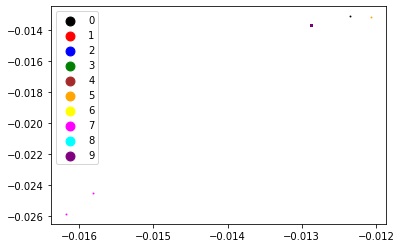

In [39]:
def test_expected_value_in_latent_space(encoder):
    with torch.no_grad():
        zs = []
        ys = []
        for i, (data, y) in enumerate(test_loader):
            data = data.to(device)
            _z, mu, _logvar = encoder(data)
            zs.append(mu)
            ys.append(y)
        zs = torch.cat(zs)
        ys = torch.cat(ys)
    zs = zs.detach().numpy()
    ys = ys.detach().numpy()
    return zs, ys

def plot_latent_space(encoder):
    zs, ys = test_expected_value_in_latent_space(encoder)
    z1, z2 = zs.T

    cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown', 
             5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

    fig, ax = plt.subplots()
    for y in np.unique(ys):
        ix = np.where(ys == y)
        ax.scatter(z1[ix], z2[ix], c = cdict[y], label = int(y), s = 0.8)
    ax.legend(markerscale = 10)
    plt.show()

plot_latent_space(lambda x: Bmodel2.encode(x.view(-1, 784)))

In [10]:
epochs2=10

In [15]:
Bmodel = BVAE().to(device)
optimizer = optim.Adam(Bmodel.parameters(), lr=1e-2)

for epoch in range(1, epochs2 + 1):
    train_bayesian(Bmodel, optimizer, epoch)
    test_bayesian(Bmodel, epoch)
    with torch.no_grad():
        sample = torch.randn(64, 2).to(device) # 20 -> 2
        sample, _mu, _logvar = Bmodel.decode(sample)
        sample = sample.cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results_bayesian/sample_' + str(epoch) + '.png'
                  )

====> Epoch: 1 Average loss: 12151.3291
====> Test set loss: 11039.6598
====> Epoch: 2 Average loss: 8591.1742
====> Test set loss: 664.5499
====> Epoch: 3 Average loss: 424.9018
====> Test set loss: 339.4104
====> Epoch: 4 Average loss: 313.6787
====> Test set loss: 297.4967
====> Epoch: 5 Average loss: 284.6144
====> Test set loss: 276.5297
====> Epoch: 6 Average loss: 269.6785
====> Test set loss: 266.1101
====> Epoch: 7 Average loss: 261.8887
====> Test set loss: 259.3885
====> Epoch: 8 Average loss: 258.0835
====> Test set loss: 256.4854
====> Epoch: 9 Average loss: 255.7213
====> Test set loss: 256.7788
====> Epoch: 10 Average loss: 254.7709
====> Test set loss: 255.1336


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


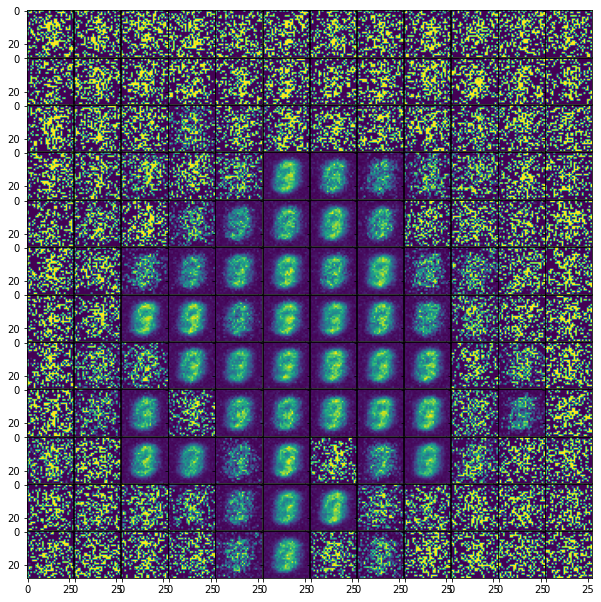

In [23]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im, _mu, _logvar = Bmodel2.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

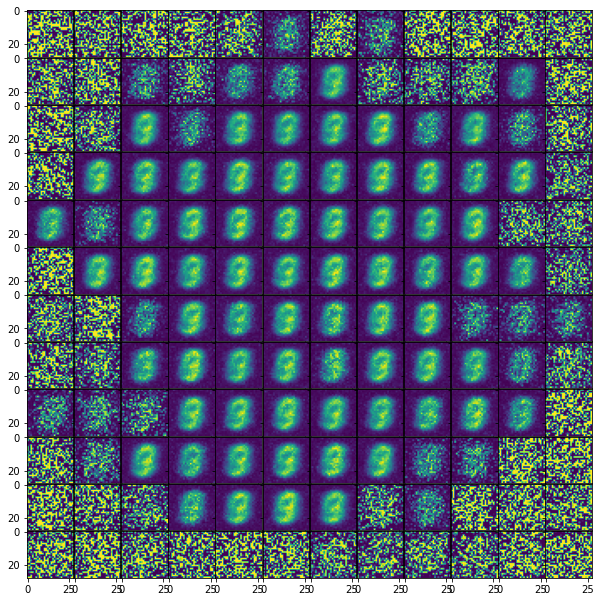

In [40]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im, _mu, _logvar = Bmodel2.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

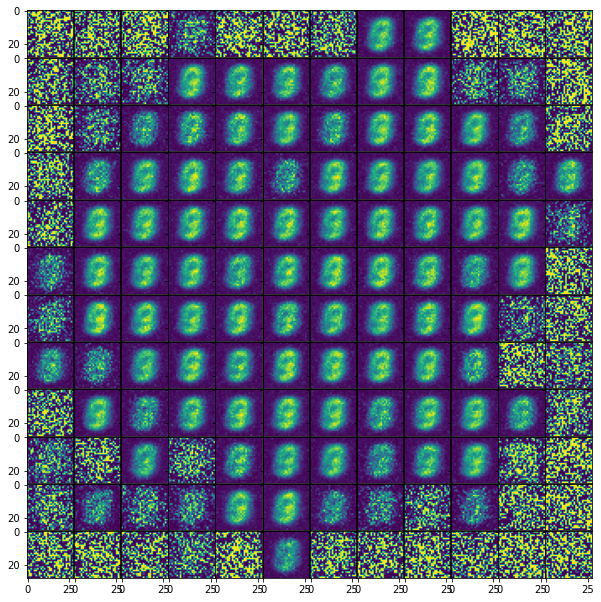

In [46]:
#+56 epochs
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im, _mu, _logvar = Bmodel2.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

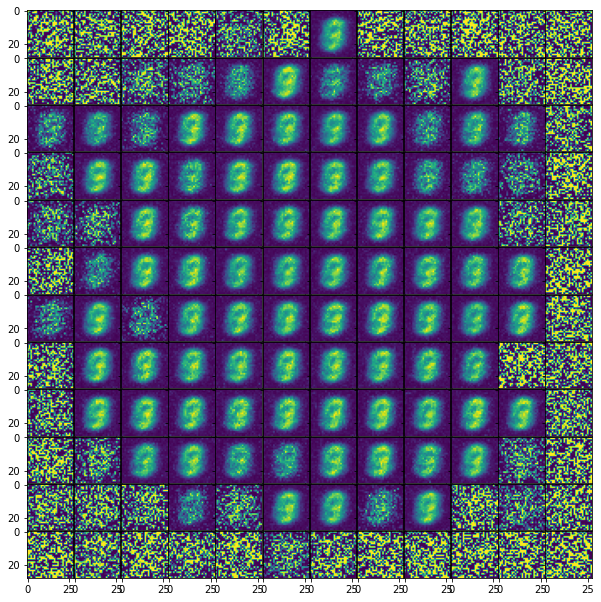

In [54]:
#+20 epochs, starting at lr=1-e-2
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]

mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc = 0, scale = 1)
gauss_x = gauss.icdf(mesh_x)#.flip(0)
gauss_y = gauss.icdf(mesh_y)

fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im, _mu, _logvar = Bmodel2.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i,j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

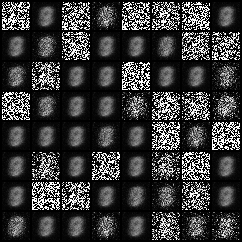

In [48]:
from IPython.display import Image
Image('results/sample_50.png')

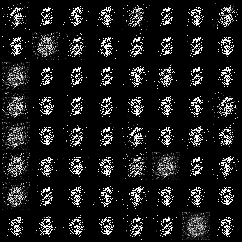

In [28]:
Image('results/sample_2.png')

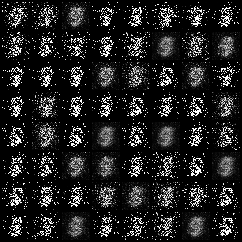

In [29]:
Image('results/sample_3.png')

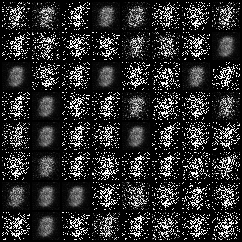

In [30]:
Image('results/sample_4.png')

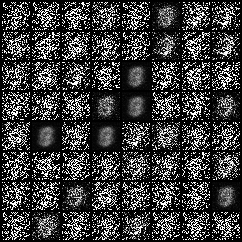

In [31]:
Image('results/sample_5.png')